In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json
from keras.utils.data_utils import Sequence
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

Using TensorFlow backend.


In [3]:
train = "/home/jose/Masaüstü/ship_dataset_700_135/train"
validation = "/home/jose/Masaüstü/ship_dataset_700_135/validation"


In [10]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train,
    batch_size=32,
    class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    validation,
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

Found 3500 images belonging to 5 classes.
Found 675 images belonging to 5 classes.


In [11]:
conv_base = ResNet50(include_top=False, weights='imagenet')

In [12]:
for layer in conv_base.layers:
    layer.trainable = False

In [13]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(5, activation='softmax')(x)
model = Model(conv_base.input, predictions)

optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [17]:
batch_size = 32
epochs = 100

history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.n/batch_size,
    epochs = epochs,
    validation_steps = 20,
    validation_data = validation_generator)

Epoch 1/3
110/109 [==============================] - 592s 5s/step - loss: 0.6510 - acc: 0.7744 - val_loss: 0.5519 - val_acc: 0.7954
Epoch 2/3
110/109 [==============================] - 486s 4s/step - loss: 0.5305 - acc: 0.8079 - val_loss: 0.7041 - val_acc: 0.7430
Epoch 3/3
110/109 [==============================] - 500s 5s/step - loss: 0.4745 - acc: 0.8298 - val_loss: 0.6362 - val_acc: 0.7791


In [21]:
# architecture and weights to HDF5
model.save('resnet_transfer_learning_model.h5')

# architecture to JSON, weights to HDF5
model.save_weights('resnet_transfer_learning_weights.h5')
with open('resnet_transfer_learning.json', 'w') as f:
    f.write(model.to_json())

In [22]:
# architecture and weights from HDF5
model = load_model('resnet_transfer_learning_model.h5')

# architecture from JSON, weights from HDF5
with open('resnet_transfer_learning.json') as f:
    model = model_from_json(f.read())
model.load_weights('resnet_transfer_learning_weights.h5')

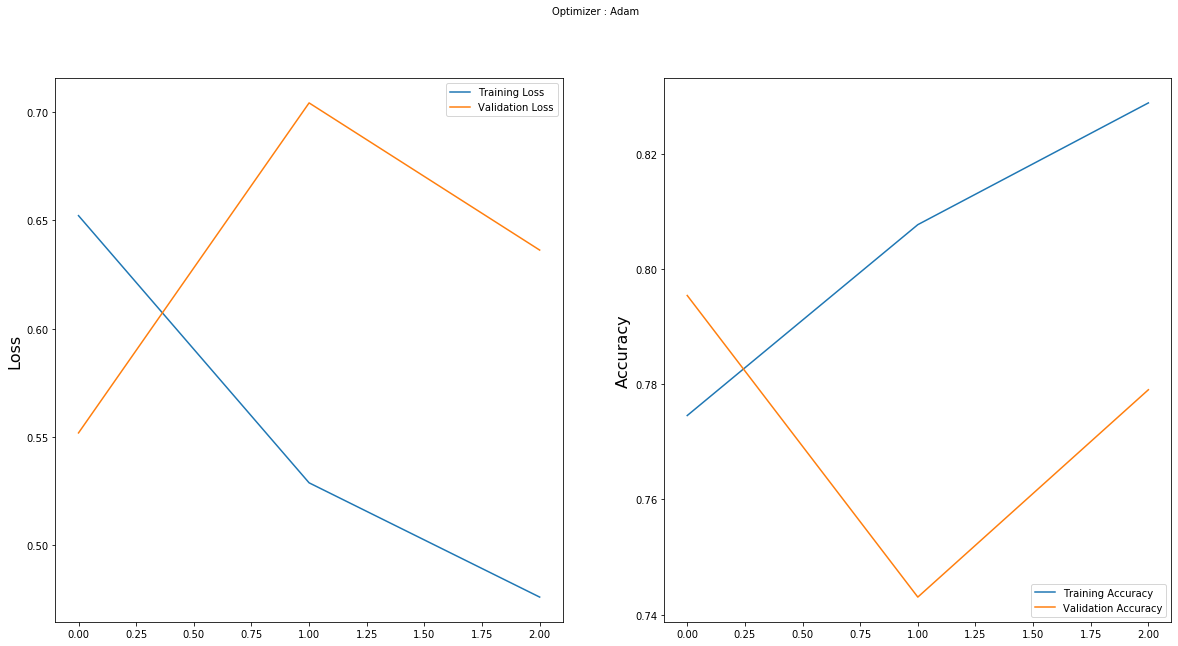

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [35]:
predictions = model.predict_generator(validation_generator, 675 // 32+1)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()
print(class_names)

dict_keys(['container', 'cruise', 'fishing', 'military', 'tanker'])


<Figure size 432x288 with 0 Axes>

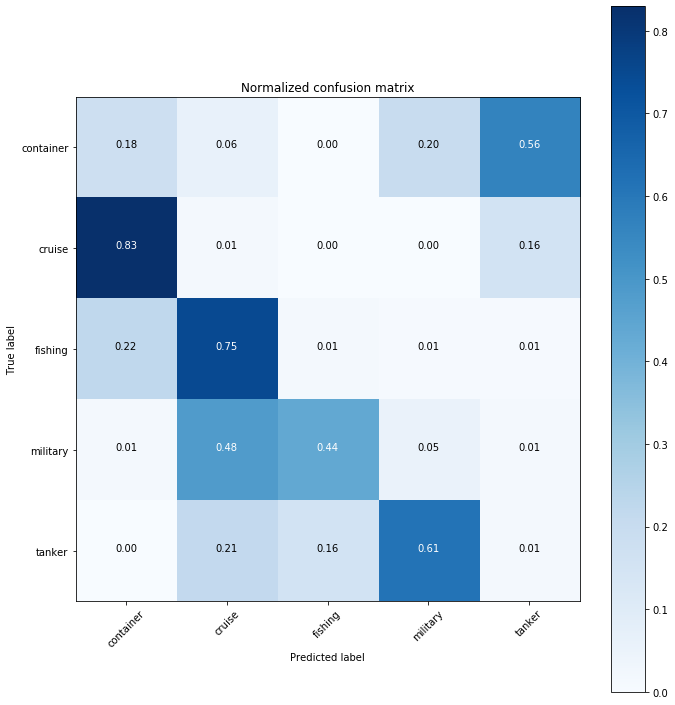

In [36]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()